## Imports

In [1]:
from ipynb.fs.full.Jacobian import *
from ipynb.fs.full.SubFunctions import *
from ipynb.fs.full.GlobalVars import *

## Solver for one differencial equation

In [78]:
def Solver_one_equation(expr, u0, use_trapezoidal, symbol):
    t0 = 0
    un_1 = u0
    un = u0
    
    velocity_n = 0
    #Need to keep in memory the previous derivative value.
    if(use_trapezoidal):
        velocity_n = expr.subs(symbol, u0)
    

    function = [u0]
    time = [t0]

    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        f_un_plus1 = 1
       
        #Newton's method
        while(nb < Nnewton):
            nb += 1
            print("velociy_n = ", end='')
            print(velocity_n)
            f = create_f(symbol, un_1, expr, use_trapezoidal, velocity_n)
            f_un = f.subs(symbol, un)
            f_un_prime = Jacobian_one(f).subs(symbol, un)
            
            un_plus1 = float(un - (f_un / f_un_prime))
            f_un_plus1 = float(f.subs(symbol, un_plus1))
            
            
            print("t0 = ", end='')
            print(t0)
            print("un = ", end='')
            print(un)
            print("f = ", end='')
            print(f)
            print("fun = ", end='')
            print(f_un)
            print("f un prime = ", end='')
            print(f_un_prime)
            print("un+1 = ", end='')
            print(un_plus1)
            print("fun+1 = ", end='')
            print(f_un_plus1)
            
            un = un_plus1
            if(f_un_plus1 < Epsilon):
                break
            
            
        #Need to keep in memory the residual of the previous iteration.
        if(use_trapezoidal):
            velocity_n = (2/delta) * (un_plus1 - un) - velocity_n
        
        un_1 = un
        print("------")
        time.append(t0)
        function.append(un_plus1)
        
    return result_solver(time, function)

velociy_n = -1
t0 = 0.01
un = 1
f = 201.0*u - 199.0
fun = 2.00000000000000
f un prime = 201.000000000000
un+1 = 0.9900497512437811
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 0.02
un = 0.9900497512437811
f = 201.0*u - 199.009950248756
fun = -0.00995024875624040
f un prime = 201.000000000000
un+1 = 0.9900992549689366
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 0.03
un = 0.9900992549689366
f = 201.0*u - 197.019850993787
fun = 1.99009925496892
f un prime = 201.000000000000
un+1 = 0.9801982636506832
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 0.04
un = 0.9801982636506832
f = 201.0*u - 197.039652730137
fun = -0.0198017363493364
f un prime = 201.000000000000
un+1 = 0.9802967797519236
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 0.05
un = 0.9802967797519236
f = 201.0*u - 195.059355950385
fun = 1.98029677975191
f un prime = 201.000000000000
un+1 = 0.9704445569670883
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 0.060000000000000005
un = 0.97044455696

t0 = 0.5800000000000003
un = 0.7481780296999995
f = 201.0*u - 150.63560594
fun = -0.251821970300000
f un prime = 201.000000000000
un+1 = 0.7494308753233826
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 0.5900000000000003
un = 0.7494308753233826
f = 201.0*u - 148.886175064677
fun = 1.74943087532338
f un prime = 201.000000000000
un+1 = 0.7407272391277439
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 0.6000000000000003
un = 0.7407272391277439
f = 201.0*u - 149.145447825549
fun = -0.259272760872250
f un prime = 201.000000000000
un+1 = 0.7420171533609391
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 0.6100000000000003
un = 0.7420171533609391
f = 201.0*u - 147.403430672188
fun = 1.74201715336093
f un prime = 201.000000000000
un+1 = 0.7333504013541683
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 0.6200000000000003
un = 0.7333504013541683
f = 201.0*u - 147.670080270834
fun = -0.266649598645841
f un prime = 201.000000000000
un+1 = 0.7346770162728044
fun+1 = 0.0
--

fun = 1.56741068018459
f un prime = 201.000000000000
un+1 = 0.559612617099091
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 1.1600000000000008
un = 0.559612617099091
f = 201.0*u - 112.922523419818
fun = -0.440387382900909
f un prime = 201.000000000000
un+1 = 0.5618035991035731
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 1.1700000000000008
un = 0.5618035991035731
f = 201.0*u - 111.360719820715
fun = 1.56180359910358
f un prime = 201.000000000000
un+1 = 0.5540334319438538
fun+1 = -1.4210854715202004e-14
------
velociy_n = 1.00000000000000
t0 = 1.1800000000000008
un = 0.5540334319438538
f = 201.0*u - 111.806686388771
fun = -0.445966568056150
f un prime = 201.000000000000
un+1 = 0.5562521710884117
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 1.1900000000000008
un = 0.5562521710884117
f = 201.0*u - 110.250434217682
fun = 1.55625217108840
f un prime = 201.000000000000
un+1 = 0.5485096229735441
fun+1 = 1.4210854715202004e-14
------
velociy_n = 1.00000000000000
t0 = 1

un = 0.41423627786819855
f = 201.0*u - 83.8472555736397
fun = -0.585763722131802
f un prime = 201.000000000000
un+1 = 0.4171505252419886
fun+1 = -1.4210854715202004e-14
------
velociy_n = -1.00000000000000
t0 = 1.7700000000000014
un = 0.4171505252419886
f = 201.0*u - 82.4301050483977
fun = 1.41715052524198
f un prime = 201.000000000000
un+1 = 0.4101000251164066
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 1.7800000000000014
un = 0.4101000251164066
f = 201.0*u - 83.0200050232813
fun = -0.589899974883593
f un prime = 201.000000000000
un+1 = 0.4130348508620961
fun+1 = 1.4210854715202004e-14
------
velociy_n = -1.00000000000000
t0 = 1.7900000000000014
un = 0.4130348508620961
f = 201.0*u - 81.6069701724192
fun = 1.41303485086210
f un prime = 201.000000000000
un+1 = 0.40600482672845384
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 1.8000000000000014
un = 0.40600482672845384
f = 201.0*u - 82.2009653456908
fun = -0.593995173271537
f un prime = 201.000000000000
un+1 = 0.408960026

t0 = 2.339999999999994
un = 0.30955554644788524
f = 201.0*u - 62.911109289577
fun = -0.690444453552111
f un prime = 201.000000000000
un+1 = 0.3129905934804828
fun+1 = -7.105427357601002e-15
------
velociy_n = -1.00000000000000
t0 = 2.349999999999994
un = 0.3129905934804828
f = 201.0*u - 61.5981186960966
fun = 1.31299059348048
f un prime = 201.000000000000
un+1 = 0.3064583019706297
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 2.3599999999999937
un = 0.3064583019706297
f = 201.0*u - 62.2916603941259
fun = -0.693541698029371
f un prime = 201.000000000000
un+1 = 0.309908758179731
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 2.3699999999999934
un = 0.309908758179731
f = 201.0*u - 60.9817516359462
fun = 1.30990875817973
f un prime = 201.000000000000
un+1 = 0.303391799183812
fun+1 = 7.105427357601002e-15
------
velociy_n = 1.00000000000000
t0 = 2.3799999999999932
un = 0.303391799183812
f = 201.0*u - 61.6783598367624
fun = -0.696608200816186
f un prime = 201.000000000000
un+1 

un = 0.23117014866817412
f = 201.0*u - 47.2340297336348
fun = -0.768829851331830
f un prime = 201.000000000000
un+1 = 0.23499517280415338
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 2.9299999999999815
un = 0.23499517280415338
f = 201.0*u - 45.9990345608307
fun = 1.23499517280415
f un prime = 201.000000000000
un+1 = 0.22885091821308798
fun+1 = 7.105427357601002e-15
------
velociy_n = 1.00000000000000
t0 = 2.9399999999999813
un = 0.22885091821308798
f = 201.0*u - 46.7701836426176
fun = -0.771149081786909
f un prime = 201.000000000000
un+1 = 0.23268748080904275
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 2.949999999999981
un = 0.23268748080904275
f = 201.0*u - 45.5374961618085
fun = 1.23268748080905
f un prime = 201.000000000000
un+1 = 0.22655470727267932
fun+1 = -7.105427357601002e-15
------
velociy_n = 1.00000000000000
t0 = 2.959999999999981
un = 0.22655470727267932
f = 201.0*u - 46.3109414545359
fun = -0.773445292727324
f un prime = 201.000000000000
un+1 = 0.2304026

fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 3.3099999999999734
un = 0.19485397405268057
f = 201.0*u - 37.9707948105361
fun = 1.19485397405268
f un prime = 201.000000000000
un+1 = 0.1889094269180901
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 3.319999999999973
un = 0.1889094269180901
f = 201.0*u - 38.781885383618
fun = -0.811090573081906
f un prime = 201.000000000000
un+1 = 0.19294470340108466
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 3.329999999999973
un = 0.19294470340108466
f = 201.0*u - 37.5889406802169
fun = 1.19294470340109
f un prime = 201.000000000000
un+1 = 0.18700965512545736
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 3.3399999999999728
un = 0.18700965512545736
f = 201.0*u - 38.4019310250915
fun = -0.812990344874542
f un prime = 201.000000000000
un+1 = 0.19105438320941032
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 3.3499999999999726
un = 0.19105438320941032
f = 201.0*u - 37.2108766418821
fun = 1.19105438320940
f un prime = 20

t0 = 3.899999999999961
un = 0.14082979718600602
f = 201.0*u - 29.1659594372012
fun = -0.859170202813996
f un prime = 201.000000000000
un+1 = 0.14510427580697116
fun+1 = -3.552713678800501e-15
------
velociy_n = -1.00000000000000
t0 = 3.9099999999999606
un = 0.14510427580697116
f = 201.0*u - 28.0208551613942
fun = 1.14510427580697
f un prime = 201.000000000000
un+1 = 0.13940723960892654
fun+1 = 3.552713678800501e-15
------
velociy_n = 1.00000000000000
t0 = 3.9199999999999604
un = 0.13940723960892654
f = 201.0*u - 28.8814479217853
fun = -0.860592760391075
f un prime = 201.000000000000
un+1 = 0.1436887956307727
fun+1 = 3.552713678800501e-15
------
velociy_n = -1.00000000000000
t0 = 3.92999999999996
un = 0.1436887956307727
f = 201.0*u - 27.7377591261545
fun = 1.14368879563077
f un prime = 201.000000000000
un+1 = 0.1379988016226594
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 3.93999999999996
un = 0.1379988016226594
f = 201.0*u - 28.5997603245319
fun = -0.862001198377339
f un prime 

velociy_n = 1.00000000000000
t0 = 4.41999999999995
un = 0.10808771083330318
f = 201.0*u - 22.6175421666606
fun = -0.891912289166697
f un prime = 201.000000000000
un+1 = 0.11252508540627182
fun+1 = -3.552713678800501e-15
------
velociy_n = -1.00000000000000
t0 = 4.42999999999995
un = 0.11252508540627182
f = 201.0*u - 21.5050170812544
fun = 1.11252508540627
f un prime = 201.000000000000
un+1 = 0.1069901347326088
fun+1 = 3.552713678800501e-15
------
velociy_n = 1.00000000000000
t0 = 4.43999999999995
un = 0.1069901347326088
f = 201.0*u - 22.3980269465218
fun = -0.893009865267391
f un prime = 201.000000000000
un+1 = 0.11143296988319283
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 4.4499999999999496
un = 0.11143296988319283
f = 201.0*u - 21.2865939766386
fun = 1.11143296988319
f un prime = 201.000000000000
un+1 = 0.10590345262009238
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 4.459999999999949
un = 0.10590345262009238
f = 201.0*u - 22.1806905240185
fun = -0.894096547379906


t0 = 4.959999999999939
un = 0.08197867639923385
f = 201.0*u - 17.3957352798468
fun = -0.918021323600765
f un prime = 201.000000000000
un+1 = 0.08654594666590433
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 4.9699999999999385
un = 0.08654594666590433
f = 201.0*u - 16.3091893331809
fun = 1.08654594666590
f un prime = 201.000000000000
un+1 = 0.08114024543871078
fun+1 = -3.552713678800501e-15
------
velociy_n = 1.00000000000000
t0 = 4.979999999999938
un = 0.08114024543871078
f = 201.0*u - 17.2280490877422
fun = -0.918859754561289
f un prime = 201.000000000000
un+1 = 0.08571168700369232
fun+1 = 3.552713678800501e-15
------
velociy_n = -1.00000000000000
t0 = 4.989999999999938
un = 0.08571168700369232
f = 201.0*u - 16.1423374007385
fun = 1.08571168700369
f un prime = 201.000000000000
un+1 = 0.0803101363220819
fun+1 = -3.552713678800501e-15
------
velociy_n = 1.00000000000000
t0 = 4.999999999999938
un = 0.0803101363220819
f = 201.0*u - 17.0620272644164
fun = -0.919689863677920
f un pr

f = 201.0*u - 11.9615431344689
fun = 1.06480771567235
f un prime = 201.000000000000
un+1 = 0.05951016484810414
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 5.5799999999999255
un = 0.05951016484810414
f = 201.0*u - 12.9020329696208
fun = -0.940489835151896
f un prime = 201.000000000000
un+1 = 0.06418921875433248
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 5.589999999999925
un = 0.06418921875433248
f = 201.0*u - 11.8378437508665
fun = 1.06418921875433
f un prime = 201.000000000000
un+1 = 0.05889474502918654
fun+1 = -1.7763568394002505e-15
------
velociy_n = 1.00000000000000
t0 = 5.599999999999925
un = 0.05889474502918654
f = 201.0*u - 12.7789490058373
fun = -0.941105254970815
f un prime = 201.000000000000
un+1 = 0.06357686072555875
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 5.609999999999925
un = 0.06357686072555875
f = 201.0*u - 11.7153721451118
fun = 1.06357686072556
f un prime = 201.000000000000
un+1 = 0.058285433557769904
fun+1 = 0.0
------
velociy_n = 1.

velociy_n = -1.00000000000000
t0 = 6.149999999999913
un = 0.04915472886425487
f = 201.0*u - 8.83094577285097
fun = 1.04915472886426
f un prime = 201.000000000000
un+1 = 0.0439350535962735
fun+1 = -1.7763568394002505e-15
------
velociy_n = 1.00000000000000
t0 = 6.159999999999913
un = 0.0439350535962735
f = 201.0*u - 9.7870107192547
fun = -0.956064946403727
f un prime = 201.000000000000
un+1 = 0.048691595618182586
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 6.169999999999913
un = 0.048691595618182586
f = 201.0*u - 8.73831912363652
fun = 1.04869159561818
f un prime = 201.000000000000
un+1 = 0.04347422449570407
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 6.179999999999913
un = 0.04347422449570407
f = 201.0*u - 9.69484489914081
fun = -0.956525775504296
f un prime = 201.000000000000
un+1 = 0.04823305919970554
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 6.1899999999999125
un = 0.04823305919970554
f = 201.0*u - 8.64661183994111
fun = 1.04823305919971
f un prime = 2

f = 201.0*u - 7.3854540120369
fun = -0.968072729939816
f un prime = 201.000000000000
un+1 = 0.03674355229869102
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 6.7699999999999
un = 0.03674355229869102
f = 201.0*u - 6.3487104597382
fun = 1.03674355229869
f un prime = 201.000000000000
un+1 = 0.031585624177802016
fun+1 = 8.881784197001252e-16
------
velociy_n = 1.00000000000000
t0 = 6.7799999999999
un = 0.031585624177802016
f = 201.0*u - 7.3171248355604
fun = -0.968414375822197
f un prime = 201.000000000000
un+1 = 0.03640360614706668
fun+1 = 8.881784197001252e-16
------
velociy_n = -1.00000000000000
t0 = 6.7899999999999
un = 0.03640360614706668
f = 201.0*u - 6.28072122941334
fun = 1.03640360614707
f un prime = 201.000000000000
un+1 = 0.031247369300563863
fun+1 = -8.881784197001252e-16
------
velociy_n = 1.00000000000000
t0 = 6.7999999999998995
un = 0.031247369300563863
f = 201.0*u - 7.24947386011277
fun = -0.968752630699436
f un prime = 201.000000000000
un+1 = 0.03606703412991429
fu

un+1 = 0.022771746449847752
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 7.379999999999887
un = 0.022771746449847752
f = 201.0*u - 5.55434928996955
fun = -0.977228253550153
f un prime = 201.000000000000
un+1 = 0.02763357855706244
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 7.389999999999887
un = 0.02763357855706244
f = 201.0*u - 4.52671571141249
fun = 1.02763357855706
f un prime = 201.000000000000
un+1 = 0.022520973688619342
fun+1 = -8.881784197001252e-16
------
velociy_n = 1.00000000000000
t0 = 7.399999999999887
un = 0.022520973688619342
f = 201.0*u - 5.50419473772387
fun = -0.977479026311381
f un prime = 201.000000000000
un+1 = 0.027384053421511786
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 7.4099999999998865
un = 0.027384053421511786
f = 201.0*u - 4.47681068430236
fun = 1.02738405342151
f un prime = 201.000000000000
un+1 = 0.02227268997165352
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 7.419999999999886
un = 0.02227268997165352
f = 201.0*u - 5.4

velociy_n = 1.00000000000000
t0 = 7.919999999999876
un = 0.016806388190045266
f = 201.0*u - 4.36127763800905
fun = -0.983193611809955
f un prime = 201.000000000000
un+1 = 0.021697898696562454
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 7.929999999999875
un = 0.021697898696562454
f = 201.0*u - 3.33957973931249
fun = 1.02169789869656
f un prime = 201.000000000000
un+1 = 0.016614824573693985
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 7.939999999999875
un = 0.016614824573693985
f = 201.0*u - 4.3229649147388
fun = -0.983385175426307
f un prime = 201.000000000000
un+1 = 0.021507288133028844
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 7.949999999999875
un = 0.021507288133028844
f = 201.0*u - 3.30145762660577
fun = 1.02150728813303
f un prime = 201.000000000000
un+1 = 0.016425162321421737
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 7.959999999999875
un = 0.016425162321421737
f = 201.0*u - 4.28503246428435
fun = -0.983574837678578
f un prime = 201.00000000

un = 0.012546575366778785
f = 201.0*u - 3.50931507335576
fun = -0.987453424633221
f un prime = 201.000000000000
un+1 = 0.01745927897191919
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 8.429999999999865
un = 0.01745927897191919
f = 201.0*u - 2.49185579438384
fun = 1.01745927897192
f un prime = 201.000000000000
un+1 = 0.012397292509372328
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 8.439999999999864
un = 0.012397292509372328
f = 201.0*u - 3.47945850187447
fun = -0.987602707490628
f un prime = 201.000000000000
un+1 = 0.01731073881529585
fun+1 = 4.440892098500626e-16
------
velociy_n = -1.00000000000000
t0 = 8.449999999999864
un = 0.01731073881529585
f = 201.0*u - 2.46214776305917
fun = 1.01731073881530
f un prime = 201.000000000000
un+1 = 0.012249491358503334
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 8.459999999999864
un = 0.012249491358503334
f = 201.0*u - 3.44989827170067
fun = -0.987750508641497
f un prime = 201.000000000000
un+1 = 0.017163672993535654
fun+

t0 = 9.039999999999852
un = 0.008546050858559216
f = 201.0*u - 2.70921017171184
fun = -0.991453949141441
f un prime = 201.000000000000
un+1 = 0.013478657570705689
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 9.049999999999851
un = 0.013478657570705689
f = 201.0*u - 1.69573151414114
fun = 1.01347865757071
f un prime = 201.000000000000
un+1 = 0.00843647519473203
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 9.059999999999851
un = 0.00843647519473203
f = 201.0*u - 2.68729503894641
fun = -0.991563524805268
f un prime = 201.000000000000
un+1 = 0.013369627059434855
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 9.069999999999851
un = 0.013369627059434855
f = 201.0*u - 1.67392541188697
fun = 1.01336962705944
f un prime = 201.000000000000
un+1 = 0.008327987123815776
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 9.07999999999985
un = 0.008327987123815776
f = 201.0*u - 2.66559742476316
fun = -0.991672012876184
f un prime = 201.000000000000
un+1 = 0.01326167873016495

t0 = 9.60999999999984
un = 0.010801762613201888
f = 201.0*u - 1.16035252264038
fun = 1.01080176261320
f un prime = 201.000000000000
un+1 = 0.005772898122588944
fun+1 = 0.0
------
velociy_n = 1.00000000000000
t0 = 9.61999999999984
un = 0.005772898122588944
f = 201.0*u - 2.15457962451779
fun = -0.994227101877411
f un prime = 201.000000000000
un+1 = 0.010719301614516362
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 9.62999999999984
un = 0.010719301614516362
f = 201.0*u - 1.14386032290327
fun = 1.01071930161452
f un prime = 201.000000000000
un+1 = 0.005690847377628221
fun+1 = 2.220446049250313e-16
------
velociy_n = 1.00000000000000
t0 = 9.639999999999839
un = 0.005690847377628221
f = 201.0*u - 2.13816947552564
fun = -0.994309152622372
f un prime = 201.000000000000
un+1 = 0.010637659082217135
fun+1 = 0.0
------
velociy_n = -1.00000000000000
t0 = 9.649999999999839
un = 0.010637659082217135
f = 201.0*u - 1.12753181644343
fun = 1.01063765908222
f un prime = 201.000000000000
un+1 = 0.0

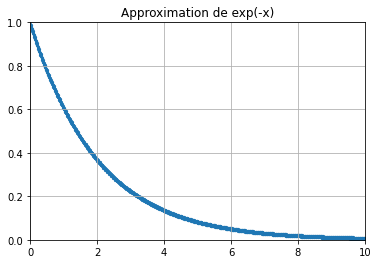

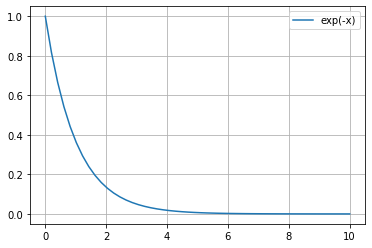

In [79]:
t = sp.Symbol('t', real=True)
u0 = 1
use_trapezoidal = True
du = -u
symbol = u
res = Solver_one_equation(du, u0, use_trapezoidal, symbol)


absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])
    
plt.ylim([0, 1])
plt.title('Approximation de exp(-x)')
plt.xlim([0, 10])
plt.scatter(absi, coords, s=5)
plt.grid(True)

fig, ax = plt.subplots()
x = np.linspace(0, 10, 50)
y = np.exp(-x)
ax.plot(x, y, label ='exp(-x)')
ax.grid(True)
plt.legend()  
plt.show()

## Solver for 2 differentials equations

In [57]:
def Solver_two_equations(u0, v0, f1, f2, use_trapezoidal):
    t0 = 0
    
    xk = np.array([u0, v0])
    xn = xk
    
    velocity_n = [0, 0]
    #Need to keep in memory the previous derivative value.
    if(use_trapezoidal):
        velocity_n = [f1.subs(v, v0), f2.subs(u, u0)]
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        f_xk_plus1 = 1
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            #Need to keep in memory the previous derivative value.
            print("velocity_n : ", end='')
            print(velocity_n)
            vec_f = create_2_f(xn, f1, f2, use_trapezoidal, velocity_n)
            F_xk = create_fxk_1(xk, vec_f)
            F_xk_prime = f_prime_2_eqs(xk, vec_f[0], vec_f[1])
            xk_plus1 = xk - np.dot(LA.inv(F_xk_prime), F_xk)
            
            
          
            #2 types of check the approximation.
            f_xk_plus1 =[0, 0]
            f_xk_plus1[0] = float(vec_f[0].evalf(subs={u: xk_plus1[0], v: xk_plus1[1]}))
            f_xk_plus1[1] = float(vec_f[1].evalf(subs={u: xk_plus1[0], v: xk_plus1[1]})) 
            
            norm_f_xk_plus1 = LA.norm(f_xk_plus1)
            #norm_xk = LA.norm(xk - xn_1_global)
            
            print("t0 = ", end='')
            print(t0)
            print("xk = ", end='')
            print(xk)
            print("vecf = ", end='')
            print(vec_f)
            print("fxk = ", end='')
            print(F_xk)
            print("fxk_prime = ", end='')
            print(F_xk_prime)
            print("xk_plus1 = ", end='')
            print(xk_plus1)
            print("norme fxk_plus1 = ", end='')
            print(norm_f_xk_plus1)
            xk = xk_plus1
            print("------------------------")
            if(norm_f_xk_plus1 < Epsilon):
                break
            
            
        
        #Need to keep in memory the residual of the previous iteration.
        if(use_trapezoidal):
            velocity_n[0] =  (2/delta) * (xk_plus1[0] - xk[0]) - velocity_n[0]
            velocity_n[1] = (2/delta) * (xk_plus1[1] - xk[1]) - velocity_n[1]
        #Update our 3 lists and indexes.
        print("_____________________________________________")
        time.append(t0)
        fu.append(xk_plus1[0])
        fv.append(xk_plus1[1])
        
        xn = np.array([xk_plus1[0],xk_plus1[1]])
      
    return result_solver(time, fu, fv)

velocity_n : [0, 1]
t0 = 0.01
xk = [1 0]
vecf = [200.0*u + v - 200.0 -u + 200.0*v - 1]
fxk = [ 3.02546243e-123 -2.00000000e+000]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [1.00005    0.00999975]
norme fxk_plus1 = 0.019999750004699633
------------------------
velocity_n : [0, 1]
t0 = 0.01
xk = [1.00005    0.00999975]
vecf = [200.0*u + v - 200.0 -u + 200.0*v - 1]
fxk = [ 1.99995000e-02 -9.99975001e-05]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.99995001 0.01000075]
norme fxk_plus1 = 0.00019999500012523021
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 0.02
xk = [0.99995001 0.01000075]
vecf = [200.0*u + v - 199.990001249944 -u + 200.0*v - 1.00014999125034]
fxk = [1.00007500e-02 4.99937503e-05]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.9999     0.01000075]
norme fxk_plus1 = 0.00010000749906257659
------------------------
_____________________________________________
velocity_n : [0, 1.000000000000

fxk = [0.01994953 0.00089857]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.99395454 0.10980207]
norme fxk_plus1 = 0.00019969505388013902
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 0.22000000000000006
xk = [0.99395454 0.10980207]
vecf = [200.0*u + v - 198.790907329231 -u + 200.0*v - 20.9604147111659]
fxk = [0.10980207 0.00604546]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.99340539 0.10977459]
norme fxk_plus1 = 0.001099669980757876
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 0.23000000000000007
xk = [0.99340539 0.10977459]
vecf = [200.0*u + v - 198.681077774097 -u + 200.0*v - 22.9549183955877]
fxk = [ 0.10977459 -1.99340539]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.99290636 0.11974411]
norme fxk_plus1 = 0.019964007275650807
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 0.23000000000000007
xk = [0.99290636 

xk_plus1 = [0.97802136 0.20853091]
norme fxk_plus1 = 0.00019889582001609367
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 0.4200000000000002
xk = [0.97802136 0.20853091]
vecf = [200.0*u + v - 195.604272912829 -u + 200.0*v - 40.7061826756095]
fxk = [0.20853091 0.02197864]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.97697819 0.20842624]
norme fxk_plus1 = 0.0020968333999718206
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 0.4300000000000002
xk = [0.97697819 0.20842624]
vecf = [200.0*u + v - 195.395637322164 -u + 200.0*v - 42.6852472181269]
fxk = [ 0.20842624 -1.97697819]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.9759855  0.21831609]
norme fxk_plus1 = 0.019879098197840856
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 0.4300000000000002
xk = [0.9759855  0.21831609]
vecf = [200.0*u + v - 195.395637322164 -u + 200.0*v - 42.68

fxk = [0.31471614 0.05079611]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.94762908 0.31447003]
norme fxk_plus1 = 0.00318785118107375
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 0.6500000000000004
xk = [0.94762908 0.31447003]
vecf = [200.0*u + v - 189.525815142945 -u + 200.0*v - 63.8940061409487]
fxk = [ 0.31447003 -1.94762908]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.94610545 0.32421579]
norme fxk_plus1 = 0.01972828709101793
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 0.6500000000000004
xk = [0.94610545 0.32421579]
vecf = [200.0*u + v - 189.525815142945 -u + 200.0*v - 63.8940061409487]
fxk = [0.01949153 0.00304724]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.94600792 0.32420105]
norme fxk_plus1 = 0.00019728040491958133
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 0.6600000000000004
xk = [0.94600792 0.324

t0 = 0.8400000000000005
xk = [0.91302043 0.40800341]
vecf = [200.0*u + v - 182.60408564802 -u + 200.0*v - 80.6006818375184]
fxk = [0.40800341 0.08697957]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.91097829 0.40757872]
norme fxk_plus1 = 0.00417166486088166
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 0.8500000000000005
xk = [0.91097829 0.40757872]
vecf = [200.0*u + v - 182.195657551676 -u + 200.0*v - 82.5157444062403]
fxk = [ 0.40757872 -1.91097829]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.90898822 0.41714356]
norme fxk_plus1 = 0.019539352559289624
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 0.8500000000000005
xk = [0.90898822 0.41714356]
vecf = [200.0*u + v - 182.195657551676 -u + 200.0*v - 82.5157444062403]
fxk = [0.01912968 0.00398014]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.90889247 0.41712414]
norme fxk_plus1 = 0.0001953910832241549
------------------------
____

xk = [0.86769307 0.49723455]
vecf = [200.0*u + v - 173.538613734295 -u + 200.0*v - 98.4469094095817]
fxk = [0.49723455 0.13230693]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.86520365 0.49658546]
norme fxk_plus1 = 0.005145295913146715
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 1.0500000000000007
xk = [0.86520365 0.49658546]
vecf = [200.0*u + v - 173.040730099681 -u + 200.0*v - 100.317091896426]
fxk = [ 0.49658546 -1.86520365]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.86276741 0.50592366]
norme fxk_plus1 = 0.019301524911741433
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 1.0500000000000007
xk = [0.86276741 0.50592366]
vecf = [200.0*u + v - 173.040730099681 -u + 200.0*v - 100.317091896426]
fxk = [0.0186764  0.00487247]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.86267391 0.50589976]
norme fxk_plus1 = 0.00019301283647941492
------------------------
_________________________

fxk = [0.01819395 0.00563349]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.81367026 0.5815157 ]
norme fxk_plus1 = 0.00019045917148356108
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 1.2400000000000009
xk = [0.81367026 0.5815157 ]
vecf = [200.0*u + v - 162.734052356857 -u + 200.0*v - 115.303139147125]
fxk = [0.5815157  0.18632974]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.8107581  0.58059861]
norme fxk_plus1 = 0.0061063078368382324
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 1.2500000000000009
xk = [0.8107581  0.58059861]
vecf = [200.0*u + v - 162.15161957325 -u + 200.0*v - 117.119721572827]
fxk = [ 0.58059861 -1.8107581 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.80790045 0.58966669]
norme fxk_plus1 = 0.019015386496757925
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 1.2500000000000009
xk = [0.80790045 0.5

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.74818145 0.65877599]
norme fxk_plus1 = 0.007052295068471078
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 1.450000000000001
xk = [0.74818145 0.65877599]
vecf = [200.0*u + v - 149.636290471022 -u + 200.0*v - 132.755198949336]
fxk = [ 0.65877599 -1.74818145]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.74493136 0.66753315]
norme fxk_plus1 = 0.01868164058825499
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 1.450000000000001
xk = [0.74493136 0.66753315]
vecf = [200.0*u + v - 149.636290471022 -u + 200.0*v - 132.755198949336]
fxk = [0.01751432 0.00650019]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.74484363 0.66750109]
norme fxk_plus1 = 0.00018681407072975993
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 1.460000000000001
xk = [0.74484363 0.66750109]
vecf = [200.0*u + v - 148

t0 = 1.6300000000000012
xk = [0.68542235 0.72349654]
vecf = [200.0*u + v - 137.084470553608 -u + 200.0*v - 145.699308884382]
fxk = [ 0.72349654 -1.68542235]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.68184709 0.73194153]
norme fxk_plus1 = 0.018341242206317818
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 1.6300000000000012
xk = [0.68184709 0.73194153]
vecf = [200.0*u + v - 137.084470553608 -u + 200.0*v - 145.699308884382]
fxk = [0.01688998 0.00715052]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.68176247 0.7319062 ]
norme fxk_plus1 = 0.00018341012945472868
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 1.6400000000000012
xk = [0.68176247 0.7319062 ]
vecf = [200.0*u + v - 136.352493691688 -u + 200.0*v - 145.381240605896]
fxk = [0.7319062  0.31823753]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.67809507 0.73033335]
norme fxk_plus1 = 0.00798088900352712
------------------------
_

norme fxk_plus1 = 0.00017963402723570408
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 1.8200000000000014
xk = [0.61313245 0.79039407]
vecf = [200.0*u + v - 122.62648987278 -u + 200.0*v - 157.078813017176]
fxk = [0.79039407 0.38686755]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.60917091 0.78847954]
norme fxk_plus1 = 0.008799829092720911
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 1.8300000000000014
xk = [0.60917091 0.78847954]
vecf = [200.0*u + v - 121.834181277656 -u + 200.0*v - 158.695907009515]
fxk = [ 0.78847954 -1.60917091]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.60526884 0.7965449 ]
norme fxk_plus1 = 0.017919404864252406
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 1.8300000000000014
xk = [0.60526884 0.7965449 ]
vecf = [200.0*u + v - 121.834181277656 -u + 200.0*v - 158.695907009515]
fxk = [0.01613073 0.0078

t0 = 2.0000000000000013
xk = [0.53950675 0.84248846]
vecf = [200.0*u + v - 107.901349238773 -u + 200.0*v - 167.497691087385]
fxk = [0.84248846 0.46049325]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.5352829  0.84020711]
norme fxk_plus1 = 0.009601134250179432
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 2.010000000000001
xk = [0.5352829  0.84020711]
vecf = [200.0*u + v - 107.056579436312 -u + 200.0*v - 169.041421682591]
fxk = [ 0.84020711 -1.5352829 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.53112035 0.84790434]
norme fxk_plus1 = 0.017501328478948683
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 2.010000000000001
xk = [0.53112035 0.84790434]
vecf = [200.0*u + v - 107.056579436312 -u + 200.0*v - 169.041421682591]
fxk = [0.01539445 0.0083251 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.53104317 0.8478631 ]
norme fxk_plus1 = 0.00017501109716493618
------------------------
___

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.46165798 0.88763386]
norme fxk_plus1 = 0.017099840712893895
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 2.1699999999999977
xk = [0.46165798 0.88763386]
vecf = [200.0*u + v - 93.2045267883844 -u + 200.0*v - 177.056384373839]
fxk = [0.01470387 0.0087293 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.46158425 0.88759058]
norme fxk_plus1 = 0.00017099626968496693
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 2.1799999999999975
xk = [0.46158425 0.88759058]
vecf = [200.0*u + v - 92.3168496522754 -u + 200.0*v - 176.518116093607]
fxk = [0.88759058 0.53841575]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.45713295 0.88492076]
norme fxk_plus1 = 0.01038114453331722
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 2.1799999999999975
xk = [0.45713295 0.88492076]
vecf = [200.0*u + v - 92.3168496522754 -u + 200.0*v - 176.51811609360

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.38929165 0.92146678]
norme fxk_plus1 = 0.00016670821239992445
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 2.339999999999994
xk = [0.38929165 0.92146678]
vecf = [200.0*u + v - 77.8583294036722 -u + 200.0*v - 183.293356830339]
fxk = [0.92146678 0.61070835]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.38466916 0.91843635]
norme fxk_plus1 = 0.011054569986293152
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 2.339999999999994
xk = [0.38466916 0.91843635]
vecf = [200.0*u + v - 77.8583294036722 -u + 200.0*v - 183.293356830339]
fxk = [-0.00606086  0.00924497]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.38469923 0.91838998]
norme fxk_plus1 = 0.00011054431806955994
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 2.349999999999994
xk = [0.38469923 0.91838998]
vecf = [200.0*u + v -

xk_plus1 = [0.30980732 0.94599996]
norme fxk_plus1 = 0.0001171002802599328
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 2.5099999999999905
xk = [0.30980732 0.94599996]
vecf = [200.0*u + v - 61.9614630502184 -u + 200.0*v - 190.199991179005]
fxk = [ 0.94599996 -1.30980732]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.30511018 0.95257248]
norme fxk_plus1 = 0.016156874259870155
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 2.5099999999999905
xk = [0.30511018 0.95257248]
vecf = [200.0*u + v - 61.9614630502184 -u + 200.0*v - 190.199991179005]
fxk = [0.01314504 0.00939427]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.30504422 0.95252584]
norme fxk_plus1 = 0.00016156672303647125
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 2.5199999999999902
xk = [0.30504422 0.95252584]
vecf = [200.0*u + v - 61.0088439304817 -u + 200.0*v - 189.5

vecf = [200.0*u + v - 46.592737335612 -u + 200.0*v - 194.506358811424]
fxk = [ 0.96753179 -1.23296369]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.22815697 0.97372065]
norme fxk_plus1 = 0.015672446582402806
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 2.669999999999987
xk = [0.22815697 0.97372065]
vecf = [200.0*u + v - 46.592737335612 -u + 200.0*v - 194.506358811424]
fxk = [0.0123777  0.00961343]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.22809484 0.97367289]
norme fxk_plus1 = 0.00015672250680315175
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 2.679999999999987
xk = [0.22809484 0.97367289]
vecf = [200.0*u + v - 45.6189689330374 -u + 200.0*v - 193.734577910694]
fxk = [0.97367289 0.77190516]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.2232073 0.9698378]
norme fxk_plus1 = 0.01242512723772181
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 2.679999999999987
x

t0 = 2.7999999999999843
xk = [0.16447025 0.98132853]
vecf = [200.0*u + v - 33.8836341504698 -u + 200.0*v - 196.091339344888]
fxk = [-0.00825634  0.00989585]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.16451128 0.98127884]
norme fxk_plus1 = 0.00012887622084315837
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 2.809999999999984
xk = [0.16451128 0.98127884]
vecf = [200.0*u + v - 32.9022559388602 -u + 200.0*v - 197.255768558036]
fxk = [ 0.98127884 -1.16451128]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.15963412 0.98712578]
norme fxk_plus1 = 0.015228055405804483
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 2.809999999999984
xk = [0.15963412 0.98712578]
vecf = [200.0*u + v - 32.9022559388602 -u + 200.0*v - 197.255768558036]
fxk = [0.01169388 0.00975432]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.15957541 0.98707731]
norme fxk_plus1 = 0.00015227865058707805
------------------------

t0 = 2.959999999999981
xk = [0.08529741 0.991131  ]
vecf = [200.0*u + v - 18.0596595131164 -u + 200.0*v - 198.13090147364]
fxk = [-0.00904701  0.01000178]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.08534239 0.99108077]
norme fxk_plus1 = 0.00013486267625239672
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 2.9699999999999807
xk = [0.08534239 0.99108077]
vecf = [200.0*u + v - 17.0684782759901 -u + 200.0*v - 199.216153897277]
fxk = [ 0.99108077 -1.08534239]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.08041424 0.99653212]
norme fxk_plus1 = 0.014697466428924834
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 2.9699999999999807
xk = [0.08041424 0.99653212]
vecf = [200.0*u + v - 17.0684782759901 -u + 200.0*v - 199.216153897277]
fxk = [0.01090271 0.00985629]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [0.08035949 0.99648311]
norme fxk_plus1 = 0.0001469728271387996
------------------------


xk_plus1 = [-0.00431186  0.99450508]
norme fxk_plus1 = 0.00014133763476487218
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 3.149999999999977
xk = [-0.00431186  0.99450508]
vecf = [200.0*u + v + 0.862372222745324 -u + 200.0*v - 199.901015244641]
fxk = [ 0.99450508 -0.99568814]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.00925937  0.99950825]
norme fxk_plus1 = 0.014072617762548494
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 3.149999999999977
xk = [-0.00925937  0.99950825]
vecf = [200.0*u + v + 0.862372222745324 -u + 200.0*v - 199.901015244641]
fxk = [0.01000636 0.00989502]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.00930965  0.99945903]
norme fxk_plus1 = 0.00014072441858174625
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 3.1599999999999766
xk = [-0.00930965  0.99945903]
vecf = [200.0*u + v + 1.8619297009158 -u + 200

t0 = 3.319999999999973
xk = [-0.09394479  0.98990814]
vecf = [200.0*u + v + 17.7882101633565 -u + 200.0*v - 198.065565916655]
fxk = [-0.01083937  0.01000748]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.09389084  0.98985784]
norme fxk_plus1 = 0.00014752495657098438
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 3.329999999999973
xk = [-0.09389084  0.98985784]
vecf = [200.0*u + v + 18.7781686134761 -u + 200.0*v - 198.971567182927]
fxk = [ 0.98985784 -0.90610916]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.09881736  0.99441301]
norme fxk_plus1 = 0.01341941622954318
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 3.329999999999973
xk = [-0.09881736  0.99441301]
vecf = [200.0*u + v + 18.7781686134761 -u + 200.0*v - 198.971567182927]
fxk = [0.00911036 0.00985303]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.09886315  0.99436398]
norme fxk_plus1 = 0.00013419248489897418
--------------

fxk = [0.98309423 1.17778312]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.18272791  0.97723003]
norme fxk_plus1 = 0.015341409594094036
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 3.4999999999999694
xk = [-0.18272791  0.97723003]
vecf = [200.0*u + v + 35.5566230137008 -u + 200.0*v - 195.618845170845]
fxk = [-0.01172838  0.00988958]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.18266951  0.97718029]
norme fxk_plus1 = 0.000153412178293318
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 3.509999999999969
xk = [-0.18266951  0.97718029]
vecf = [200.0*u + v + 36.5339027878271 -u + 200.0*v - 196.436058870472]
fxk = [ 0.97718029 -0.81733049]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.18753486  0.98129127]
norme fxk_plus1 = 0.012739191023640356
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 3.509999999999969
xk = [-0.18753486  0.98129127]
vecf = [200.0*u + v + 36.53

t0 = 3.6699999999999657
xk = [-0.2651088   0.96297654]
vecf = [200.0*u + v + 52.0662270712791 -u + 200.0*v - 192.850862118866]
fxk = [0.00744447 0.00955532]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.26514626  0.96292895]
norme fxk_plus1 = 0.00012112825849379883
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 3.6799999999999655
xk = [-0.26514626  0.96292895]
vecf = [200.0*u + v + 53.0292512038011 -u + 200.0*v - 191.585790783393]
fxk = [0.96292895 1.26514626]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.26999241  0.95662745]
norme fxk_plus1 = 0.015898943440719997
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 3.6799999999999655
xk = [-0.26999241  0.95662745]
vecf = [200.0*u + v + 53.0292512038011 -u + 200.0*v - 191.585790783393]
fxk = [-0.012603   0.0096923]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.26992964  0.95657868]
norme fxk_plus1 = 0.00015898744708368916
------------

velocity_n : [0, -1.00000000000000]
t0 = 3.839999999999962
xk = [-0.34571512  0.93179768]
vecf = [200.0*u + v + 68.1978633957858 -u + 200.0*v - 186.695800019051]
fxk = [-0.01336264  0.0094516 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.34564854  0.93175009]
norme fxk_plus1 = 0.00016367227123656702
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 3.849999999999962
xk = [-0.34564854  0.93175009]
vecf = [200.0*u + v + 69.1297086691961 -u + 200.0*v - 187.350018325263]
fxk = [ 0.93175009 -0.65435146]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.35029082  0.93504506]
norme fxk_plus1 = 0.011385524381987625
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 3.849999999999962
xk = [-0.35029082  0.93504506]
vecf = [200.0*u + v + 69.1297086691961 -u + 200.0*v - 187.350018325263]
fxk = [0.00658994 0.00928455]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.350324   0.9349988]
norme fxk_plus1 = 0.

t0 = 3.979999999999959
xk = [-0.41015006  0.90517093]
vecf = [200.0*u + v + 81.1108318560662 -u + 200.0*v - 181.43514352069]
fxk = [-0.01400958  0.00919181]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.41008025  0.90512462]
norme fxk_plus1 = 0.00016755615946461135
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 3.989999999999959
xk = [-0.41008025  0.90512462]
vecf = [200.0*u + v + 82.0160490904933 -u + 200.0*v - 182.024923642493]
fxk = [ 0.90512462 -0.58991975]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.41459101  0.90809677]
norme fxk_plus1 = 0.010803826686086959
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 3.989999999999959
xk = [-0.41459101  0.90809677]
vecf = [200.0*u + v + 82.0160490904933 -u + 200.0*v - 182.024923642493]
fxk = [0.00594431 0.00902152]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.41462095  0.90805181]
norme fxk_plus1 = 0.00010803691640163193
--------------

vecf = [200.0*u + v + 94.4961554081176 -u + 200.0*v - 175.812569494637]
fxk = [ 0.87406285 -0.52751922]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.47683779  0.87672223]
norme fxk_plus1 = 0.010208997678599674
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 4.129999999999956
xk = [-0.47683779  0.87672223]
vecf = [200.0*u + v + 94.4961554081176 -u + 200.0*v - 175.812569494637]
fxk = [0.00531876 0.00871403]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.47686461  0.87667879]
norme fxk_plus1 = 0.00010208870068147237
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 4.139999999999956
xk = [-0.47686461  0.87667879]
vecf = [200.0*u + v + 95.3729210729106 -u + 200.0*v - 174.335758511257]
fxk = [0.87667879 1.47686461]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.48128481  0.86931657]
norme fxk_plus1 = 0.01717446076990882
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 4.139

t0 = 4.329999999999952
xk = [-0.55733977  0.82260193]
vecf = [200.0*u + v + 111.467953110059 -u + 200.0*v - 165.520385232414]
fxk = [ 0.82260193 -0.44266023]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.56144161  0.82483574]
norme fxk_plus1 = 0.009341307173421633
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 4.339999999999952
xk = [-0.56144161  0.82483574]
vecf = [200.0*u + v + 112.288321225846 -u + 200.0*v - 163.967147307443]
fxk = [0.82483574 1.56144161]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.56560472  0.81704934]
norme fxk_plus1 = 0.017658923869303317
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 4.339999999999952
xk = [-0.56560472  0.81704934]
vecf = [200.0*u + v + 112.288321225846 -u + 200.0*v - 163.967147307443]
fxk = [-0.01557278  0.00832622]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.56552706  0.81700732]
norme fxk_plus1 = 0.00017658703135745336
-------------

velocity_n : [0, -1.00000000000000]
t0 = 4.559999999999947
xk = [-0.64795326  0.7584595 ]
vecf = [200.0*u + v + 129.590651759457 -u + 200.0*v - 150.691900991215]
fxk = [0.7584595  1.64795326]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.65178666  0.75023891]
norme fxk_plus1 = 0.01814091643393297
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 4.559999999999947
xk = [-0.65178666  0.75023891]
vecf = [200.0*u + v + 129.590651759457 -u + 200.0*v - 150.691900991215]
fxk = [-0.0164412  0.0076668]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.65170465  0.75020016]
norme fxk_plus1 = 0.0001814068967627763
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 4.569999999999947
xk = [-0.65170465  0.75020016]
vecf = [200.0*u + v + 130.340929409188 -u + 200.0*v - 151.040032319623]
fxk = [ 0.75020016 -0.34829535]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.65544685  0.75196035]
norme fxk_plus1 = 0.0

xk_plus1 = [-0.72667688  0.68296644]
norme fxk_plus1 = 0.007355913078666213
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 4.7799999999999425
xk = [-0.72667688  0.68296644]
vecf = [200.0*u + v + 145.335376739216 -u + 200.0*v - 135.593287647637]
fxk = [0.68296644 1.72667688]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.7301348   0.67435034]
norme fxk_plus1 = 0.018568171752228
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 4.7799999999999425
xk = [-0.7301348   0.67435034]
vecf = [200.0*u + v + 145.335376739216 -u + 200.0*v - 135.593287647637]
fxk = [-0.01723219  0.00691583]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.73004881  0.67431533]
norme fxk_plus1 = 0.00018567939653791536
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 4.789999999999942
xk = [-0.73004881  0.67431533]
vecf = [200.0*u + v + 146.009762091656 -u + 200.0*v

vecf = [200.0*u + v + 157.53077533204 -u + 200.0*v - 122.222032730381]
fxk = [ 0.60611016 -0.21234612]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.79067904  0.60718702]
norme fxk_plus1 = 0.006422227770223307
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 4.979999999999938
xk = [-0.79067904  0.60718702]
vecf = [200.0*u + v + 158.135808639243 -u + 200.0*v - 120.437404020257]
fxk = [0.60718702 1.79067904]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.79375967  0.59824903]
norme fxk_plus1 = 0.01890798279871991
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 4.979999999999938
xk = [-0.79375967  0.59824903]
vecf = [200.0*u + v + 158.135808639243 -u + 200.0*v - 120.437404020257]
fxk = [-0.01787598  0.00616125]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.79367044  0.59821778]
norme fxk_plus1 = 0.0001890774645298619
------------------------
_____________________________________________

xk_plus1 = [-0.84939095  0.51612821]
norme fxk_plus1 = 0.00019200372419163399
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 5.189999999999934
xk = [-0.84939095  0.51612821]
vecf = [200.0*u + v + 169.878189894317 -u + 200.0*v - 104.225641540776]
fxk = [ 0.51612821 -0.15060905]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.85196776  0.51689414]
norme fxk_plus1 = 0.005376468973997288
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 5.199999999999934
xk = [-0.85196776  0.51689414]
vecf = [200.0*u + v + 170.393552172711 -u + 200.0*v - 102.378827402696]
fxk = [0.51689414 1.85196776]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.85459846  0.50764745]
norme fxk_plus1 = 0.01922725075085687
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 5.199999999999934
xk = [-0.85459846  0.50764745]
vecf = [200.0*u + v + 170.393552172711 -u + 200.0*v

norme fxk_plus1 = 0.000194668833215995
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 5.409999999999929
xk = [-0.90089081  0.41988614]
vecf = [200.0*u + v + 180.178161792575 -u + 200.0*v - 84.9772285289789]
fxk = [ 0.41988614 -0.09910919]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.90298771  0.42039217]
norme fxk_plus1 = 0.004314189975816565
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 5.419999999999929
xk = [-0.90298771  0.42039217]
vecf = [200.0*u + v + 180.597541904762 -u + 200.0*v - 83.078434620577]
fxk = [0.42039217 1.90298771]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.90513719  0.41088798]
norme fxk_plus1 = 0.019488450045827627
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 5.419999999999929
xk = [-0.90513719  0.41088798]
vecf = [200.0*u + v + 180.597541904762 -u + 200.0*v - 83.078434620577]
fxk = [-0.01900838 

t0 = 5.619999999999925
xk = [-0.93993221  0.32825284]
vecf = [200.0*u + v + 187.986442273276 -u + 200.0*v - 64.6505678245674]
fxk = [0.32825284 1.93993221]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.94162193  0.31856163]
norme fxk_plus1 = 0.019674831984881024
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 5.619999999999925
xk = [-0.94162193  0.31856163]
vecf = [200.0*u + v + 187.986442273276 -u + 200.0*v - 64.6505678245674]
fxk = [-0.01938242  0.00337944]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.94152511  0.31854425]
norme fxk_plus1 = 0.00019674586053757798
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 5.629999999999924
xk = [-0.94152511  0.31854425]
vecf = [200.0*u + v + 188.305021281272 -u + 200.0*v - 64.7088490677253]
fxk = [ 0.31854425 -0.05847489]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.94311633  0.31884458]
norme fxk_plus1 = 0.0032386282164090625
-------------

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.96972978  0.22318006]
norme fxk_plus1 = 0.0022521224283871223
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 5.83999999999992
xk = [-0.96972978  0.22318006]
vecf = [200.0*u + v + 193.945956509446 -u + 200.0*v - 43.6360125079555]
fxk = [0.22318006 1.96972978]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.9708949   0.21333724]
norme fxk_plus1 = 0.019823083811329176
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 5.83999999999992
xk = [-0.9708949   0.21333724]
vecf = [200.0*u + v + 193.945956509446 -u + 200.0*v - 43.6360125079555]
fxk = [-0.01968565  0.00233023]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.97079653  0.2133251 ]
norme fxk_plus1 = 0.00019822836027439964
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 5.84999999999992
xk = [-0.97079653  0.2133251 ]
vecf = [200.0

xk_plus1 = [-0.98724078  0.11537487]
norme fxk_plus1 = 0.0001990562282165904
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 6.0499999999999154
xk = [-0.98724078  0.11537487]
vecf = [200.0*u + v + 197.448156959992 -u + 200.0*v - 24.0749739026871]
fxk = [ 0.11537487 -0.01275922]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.98781733  0.11544155]
norme fxk_plus1 = 0.0011607679028220197
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 6.059999999999915
xk = [-0.98781733  0.11544155]
vecf = [200.0*u + v + 197.563465150725 -u + 200.0*v - 22.0883096588408]
fxk = [0.11544155 1.98781733]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.98844421  0.1055056 ]
norme fxk_plus1 = 0.019911417216020893
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 6.059999999999915
xk = [-0.98844421  0.1055056 ]
vecf = [200.0*u + v + 197.563465150725 -u + 200.0

t0 = 6.259999999999911
xk = [-0.99403798  0.00630991]
vecf = [200.0*u + v + 198.78134875257 -u + 200.0*v - 2.25575686988822]
fxk = [-0.01993776  0.00026248]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.9939383  0.0063081]
norme fxk_plus1 = 0.00019939233467331597
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 6.269999999999911
xk = [-0.9939383  0.0063081]
vecf = [200.0*u + v + 198.787660470174 -u + 200.0*v - 2.26161920809463]
fxk = [ 0.0063081 -0.0060617]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.99396969  0.00633856]
norme fxk_plus1 = 8.748390748641435e-05
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 6.2799999999999105
xk = [-0.99396969  0.00633856]
vecf = [200.0*u + v + 198.793938100785 -u + 200.0*v - 0.267712293896815]
fxk = [0.00633856 1.99396969]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.99405123 -0.00363088]
norme fxk_p

norme fxk_plus1 = 0.019912791520527426
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 6.479999999999906
xk = [-0.98872001 -0.10286839]
vecf = [200.0*u + v + 197.826974697507 -u + 200.0*v + 19.5841290288896]
fxk = [-0.0198955  -0.00082973]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.98862051 -0.10286474]
norme fxk_plus1 = 0.00019912542615280613
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 6.489999999999906
xk = [-0.98862051 -0.10286474]
vecf = [200.0*u + v + 197.724102652507 -u + 200.0*v + 19.5729485336376]
fxk = [-0.10286474 -0.01137949]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.98810592 -0.10281042]
norme fxk_plus1 = 0.0010349096696381677
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 6.499999999999906
xk = [-0.98810592 -0.10281042]
vecf = [200.0*u + v + 197.621183585381 -u + 200.0*v + 21.5620836422357]
fxk = [-0.10

vecf = [200.0*u + v + 194.68108498898 -u + 200.0*v + 39.218771907874]
fxk = [-0.20109386 -0.02659458]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.97239932 -0.20096592]
norme fxk_plus1 = 0.0020284226172626414
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 6.699999999999902
xk = [-0.97239932 -0.20096592]
vecf = [200.0*u + v + 194.47986318711 -u + 200.0*v + 41.1931834418283]
fxk = [-0.20096592  1.97239932]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.97144382 -0.21083269]
norme fxk_plus1 = 0.019825862138074173
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 6.699999999999902
xk = [-0.97144382 -0.21083269]
vecf = [200.0*u + v + 194.47986318711 -u + 200.0*v + 41.1931834418283]
fxk = [-0.01973355 -0.00191099]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.97134511 -0.21082363]
norme fxk_plus1 = 0.00019825614319574672
------------------------
___________________________________________

vecf = [200.0*u + v + 189.08624995301 -u + 200.0*v + 60.3630245106936]
fxk = [-0.30681512 -0.05456875]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.94389585 -0.30654996]
norme fxk_plus1 = 0.0031162612239400227
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 6.919999999999897
xk = [-0.94389585 -0.30654996]
vecf = [200.0*u + v + 188.779169663713 -u + 200.0*v + 62.3099911619051]
fxk = [-0.30654996  1.94389585]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.94241173 -0.31627686]
norme fxk_plus1 = 0.019678940848891716
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 6.919999999999897
xk = [-0.94241173 -0.31627686]
vecf = [200.0*u + v + 188.779169663713 -u + 200.0*v + 62.3099911619051]
fxk = [-0.0194538  -0.00296823]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.94231439 -0.3162625 ]
norme fxk_plus1 = 0.000196786948664871
------------------------
__________________________________________

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.90610481 -0.40887346]
norme fxk_plus1 = 0.019493673499737116
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 7.119999999999893
xk = [-0.90610481 -0.40887346]
vecf = [200.0*u + v + 181.61073633954 -u + 200.0*v + 80.8646890018037]
fxk = [-0.01910003 -0.00389773]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.90600922 -0.40885445]
norme fxk_plus1 = 0.0001949342983270264
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 7.129999999999892
xk = [-0.90600922 -0.40885445]
vecf = [200.0*u + v + 181.201843871091 -u + 200.0*v + 80.770889411521]
fxk = [-0.40885445 -0.09399078]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.90396265 -0.40839473]
norme fxk_plus1 = 0.004195137970669797
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 7.139999999999892
xk = [-0.90396265 -0.40839473]
vecf = [200.

xk = [-0.86072355 -0.49740488]
vecf = [200.0*u + v + 172.623460078184 -u + 200.0*v + 98.6154641120033]
fxk = [-0.01865511 -0.0047875 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.86063016 -0.49738141]
norme fxk_plus1 = 0.00019259387533029484
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 7.329999999999888
xk = [-0.86063016 -0.49738141]
vecf = [200.0*u + v + 172.126031731854 -u + 200.0*v + 98.4762810564727]
fxk = [-0.49738141 -0.13936984]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.85813983 -0.49669701]
norme fxk_plus1 = 0.005165322302216074
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 7.339999999999888
xk = [-0.85813983 -0.49669701]
vecf = [200.0*u + v + 171.62796592901 -u + 200.0*v + 100.339401544146]
fxk = [-0.49669701  1.85813983]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.85570286 -0.50599989]
norme fxk_plus1 = 0.019233561

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.80086181 -0.58903709]
norme fxk_plus1 = 0.01894652737933153
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 7.539999999999884
xk = [-0.80086181 -0.58903709]
vecf = [200.0*u + v + 160.743334221642 -u + 200.0*v + 117.000846626486]
fxk = [-0.01806572 -0.00570971]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.80077135 -0.58900899]
norme fxk_plus1 = 0.0001894629055260118
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 7.5499999999998835
xk = [-0.80077135 -0.58900899]
vecf = [200.0*u + v + 160.154269034646 -u + 200.0*v + 116.801798909775]
fxk = [-0.58900899 -0.19922865]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.79782139 -0.5880276 ]
norme fxk_plus1 = 0.006217829100362815
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 7.559999999999883
xk = [-0.79782139 -0.5880276 ]
vecf = [20

vecf = [200.0*u + v + 147.580325707305 -u + 200.0*v + 132.234333290425]
fxk = [-0.66617167 -0.26209837]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.7345643  -0.66487786]
norme fxk_plus1 = 0.0071586830759775314
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 7.759999999999879
xk = [-0.7345643  -0.66487786]
vecf = [200.0*u + v + 146.912860235632 -u + 200.0*v + 133.97557224632]
fxk = [-0.66487786  1.7345643 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.73128336 -0.67356709]
norme fxk_plus1 = 0.018576031917599465
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 7.759999999999879
xk = [-0.73128336 -0.67356709]
vecf = [200.0*u + v + 146.912860235632 -u + 200.0*v + 133.97557224632]
fxk = [-0.01737845 -0.00656189]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.7311963  -0.67353471]
norme fxk_plus1 = 0.00018575799722640574
------------------------
_________________________________________

fxk = [-0.78784213 -0.39346234]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.60258871 -0.78589456]
norme fxk_plus1 = 0.0088061822025022
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 8.119999999999871
xk = [-0.60258871 -0.78589456]
vecf = [200.0*u + v + 120.517741336277 -u + 200.0*v + 158.178912405452]
fxk = [-0.78589456  1.60258871]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.5986994  -0.79392695]
norme fxk_plus1 = 0.01784892483981192
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 8.119999999999871
xk = [-0.5986994  -0.79392695]
vecf = [200.0*u + v + 120.517741336277 -u + 200.0*v + 158.178912405452]
fxk = [-0.01606478 -0.00777862]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.59861888 -0.79388846]
norme fxk_plus1 = 0.0001784870173259608
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 8.129999999999871
xk = [-0.598

xk_plus1 = [-0.5119881  -0.84749413]
norme fxk_plus1 = 0.009779091407209048
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 8.339999999999867
xk = [-0.5119881  -0.84749413]
vecf = [200.0*u + v + 102.397620481708 -u + 200.0*v + 170.498826655756]
fxk = [-0.84749413  1.5119881 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.50778854 -0.85507507]
norme fxk_plus1 = 0.017332856720060522
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 8.339999999999867
xk = [-0.50778854 -0.85507507]
vecf = [200.0*u + v + 102.397620481708 -u + 200.0*v + 170.498826655756]
fxk = [-0.01516188 -0.00839913]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.50771252 -0.85503346]
norme fxk_plus1 = 0.0001733264006245745
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 8.349999999999866
xk = [-0.50771252 -0.85503346]
vecf = [200.0*u + v + 101.542503794515 -u + 200.0

fxk = [-0.89278883 -0.56219002]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.43333209 -0.89000027]
norme fxk_plus1 = 0.01055036342783814
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 8.509999999999863
xk = [-0.43333209 -0.89000027]
vecf = [200.0*u + v + 87.5619958211308 -u + 200.0*v + 177.55776572816]
fxk = [ 0.00557712 -0.00895577]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.43335975 -0.88995535]
norme fxk_plus1 = 0.00010550231550561428
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 8.519999999999863
xk = [-0.43335975 -0.88995535]
vecf = [200.0*u + v + 86.6719506359852 -u + 200.0*v + 178.991070159299]
fxk = [-0.88995535  1.43335975]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.42894592 -0.89714422]
norme fxk_plus1 = 0.016871483475704642
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 8.519999999999863
xk = [-0.42894592 -0.89714422]
vecf = [200.0*u + v + 86.

vecf = [200.0*u + v + 72.1149156258854 -u + 200.0*v + 185.310044139211]
fxk = [-0.01365148 -0.00914724]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.35593247 -0.92833057]
norme fxk_plus1 = 0.00016432537771613614
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 8.68999999999986
xk = [-0.35593247 -0.92833057]
vecf = [200.0*u + v + 71.1864942703846 -u + 200.0*v + 184.666113579321]
fxk = [-0.92833057 -0.64406753]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.35127483 -0.92513352]
norme fxk_plus1 = 0.0112986225267962
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 8.68999999999986
xk = [-0.35127483 -0.92513352]
vecf = [200.0*u + v + 71.1864942703846 -u + 200.0*v + 184.666113579321]
fxk = [ 0.0063941  -0.00931528]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.35130657 -0.92508678]
norme fxk_plus1 = 0.00011298481296827434
------------------------
____________________________________________

t0 = 8.839999999999856
xk = [-0.28551212 -0.94722175]
vecf = [200.0*u + v + 57.1024233208084 -u + 200.0*v + 190.444350541597]
fxk = [-0.94722175  1.28551212]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.28080826 -0.95367283]
norme fxk_plus1 = 0.015967801063617424
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 8.839999999999856
xk = [-0.28080826 -0.95367283]
vecf = [200.0*u + v + 57.1024233208084 -u + 200.0*v + 190.444350541597]
fxk = [-0.01290216 -0.00940771]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.28074352 -0.95362612]
norme fxk_plus1 = 0.00015967601470160742
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 8.849999999999856
xk = [-0.28074352 -0.95362612]
vecf = [200.0*u + v + 56.1487037734388 -u + 200.0*v + 189.725223549209]
fxk = [-0.95362612 -0.71925648]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.27595753 -0.95005377]
norme fxk_plus1 = 0.011944442183183456
------------

norme fxk_plus1 = 0.01249378770530554
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 8.989999999999853
xk = [-0.20861458 -0.96685703]
vecf = [200.0*u + v + 42.6975894688433 -u + 200.0*v + 193.153045504242]
fxk = [ 0.00781639 -0.00974673]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.20865342 -0.96680811]
norme fxk_plus1 = 0.00012493631535270835
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 8.999999999999853
xk = [-0.20865342 -0.96680811]
vecf = [200.0*u + v + 41.7306835068924 -u + 200.0*v + 194.361621247186]
fxk = [-0.96680811  1.20865342]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.20384971 -0.97287539]
norme fxk_plus1 = 0.015477406470309403
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 8.999999999999853
xk = [-0.20384971 -0.97287539]
vecf = [200.0*u + v + 41.7306835068924 -u + 200.0*v + 194.361621247186]
fxk = [-0.01213457 -0.00960741]
fxk_prime = [[200.  -1.]
 [ 

xk = [-0.15012645 -0.97742908]
vecf = [200.0*u + v + 30.0252906509883 -u + 200.0*v + 196.485816159354]
fxk = [-0.97742908  1.15012645]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.14526818 -0.983204  ]
norme fxk_plus1 = 0.015093381045768335
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 9.11999999999985
xk = [-0.14526818 -0.983204  ]
vecf = [200.0*u + v + 30.0252906509883 -u + 200.0*v + 196.485816159354]
fxk = [-0.01154985 -0.00971654]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.14521019 -0.98315571]
norme fxk_plus1 = 0.00015093192381229734
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 9.12999999999985
xk = [-0.14521019 -0.98315571]
vecf = [200.0*u + v + 29.042038353817 -u + 200.0*v + 195.631142332524]
fxk = [-0.98315571 -0.85478981]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.14027317 -0.97890645]
norme fxk_plus1 = 0.013027733260904553
------------------------
velocity_n : 

vecf = [200.0*u + v + 11.2923408684597 -u + 200.0*v + 197.403294323493]
fxk = [-0.99201647 -0.9435383 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.05147816 -0.9873237 ]
norme fxk_plus1 = 0.013690560023149641
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 9.309999999999846
xk = [-0.05147816 -0.9873237 ]
vecf = [200.0*u + v + 11.2923408684597 -u + 200.0*v + 197.403294323493]
fxk = [ 0.00938555 -0.00996709]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.05152484 -0.98727363]
norme fxk_plus1 = 0.0001369038889369155
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 9.319999999999846
xk = [-0.05152484 -0.98727363]
vecf = [200.0*u + v + 10.3049671017401 -u + 200.0*v + 198.454725804215]
fxk = [-0.98727363  1.05152484]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [-0.04661488 -0.9925558 ]
norme fxk_plus1 = 0.014423458979065804
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 9

vecf = [200.0*u + v - 5.54782577012646 -u + 200.0*v + 198.605377348503]
fxk = [-0.98802689  0.97226087]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.03265483 -0.99291277]
norme fxk_plus1 = 0.013861602701297403
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 9.479999999999842
xk = [ 0.03265483 -0.99291277]
vecf = [200.0*u + v - 5.54782577012646 -u + 200.0*v + 198.605377348503]
fxk = [-0.00977177 -0.00983141]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.03270394 -0.99286386]
norme fxk_plus1 = 0.0001386142943445605
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 9.489999999999842
xk = [ 0.03270394 -0.99286386]
vecf = [200.0*u + v - 6.54078745128308 -u + 200.0*v + 197.572771618019]
fxk = [-0.99286386 -1.03270394]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.03769395 -0.98772529]
norme fxk_plus1 = 0.014325518341783009
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 9.

fxk = [-0.98688572 -1.11172885]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.11669095 -0.98135189]
norme fxk_plus1 = 0.014865494334918947
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 9.649999999999839
xk = [ 0.11669095 -0.98135189]
vecf = [200.0*u + v - 22.3457697012445 -u + 200.0*v + 196.377144709878]
fxk = [ 0.01106767 -0.0099242 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.11663586 -0.98130199]
norme fxk_plus1 = 0.00014865308519869386
------------------------
_____________________________________________
velocity_n : [0, -1.00000000000000]
t0 = 9.659999999999838
xk = [ 0.11663586 -0.98130199]
vecf = [200.0*u + v - 23.3271714874624 -u + 200.0*v + 197.26039867473]
fxk = [-0.98130199  0.88336414]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.12152016 -0.98574324]
norme fxk_plus1 = 0.013203189877855171
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 9.659999999999838
xk = [ 0.12152016 -0.98574324]
vecf = [200.0*u + v - 23

fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.19967416 -0.97268835]
norme fxk_plus1 = 0.012595576299380297
------------------------
velocity_n : [0, -1.00000000000000]
t0 = 9.819999999999835
xk = [ 0.19967416 -0.97268835]
vecf = [200.0*u + v - 38.9702437823224 -u + 200.0*v + 194.727698131384]
fxk = [-0.00809972 -0.00964589]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.1997149  -0.97264032]
norme fxk_plus1 = 0.00012595418857111405
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 9.829999999999835
xk = [ 0.1997149  -0.97264032]
vecf = [200.0*u + v - 39.9429801573386 -u + 200.0*v + 193.528064708027]
fxk = [-0.97264032 -1.1997149 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.20460797 -0.96666621]
norme fxk_plus1 = 0.015444369232860706
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 9.829999999999835
xk = [ 0.20460797 -0.96666621]
vecf = [200.0*u + v - 39.9429801573386 -u + 200.0*v + 19

vecf = [200.0*u + v - 54.357780723947 -u + 200.0*v + 190.95362829556]
fxk = [-0.00732942 -0.00946103]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.2765563  -0.95338573]
norme fxk_plus1 = 0.00011967787216386106
------------------------
_____________________________________________
velocity_n : [0, 1.00000000000000]
t0 = 9.989999999999831
xk = [ 0.2765563  -0.95338573]
vecf = [200.0*u + v - 55.3112606942508 -u + 200.0*v + 189.677145757458]
fxk = [-0.95338573 -1.2765563 ]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.28135503 -0.94702694]
norme fxk_plus1 = 0.015932598287366186
------------------------
velocity_n : [0, 1.00000000000000]
t0 = 9.989999999999831
xk = [ 0.28135503 -0.94702694]
vecf = [200.0*u + v - 55.3112606942508 -u + 200.0*v + 189.677145757458]
fxk = [ 0.01271758 -0.00959745]
fxk_prime = [[200.  -1.]
 [  1. 200.]]
xk_plus1 = [ 0.28129168 -0.94697864]
norme fxk_plus1 = 0.00015932399133918417
------------------------
__________________________________________

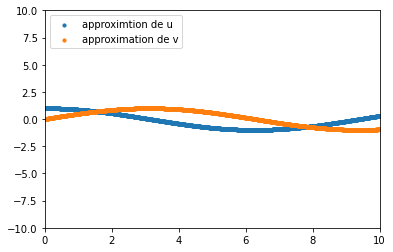

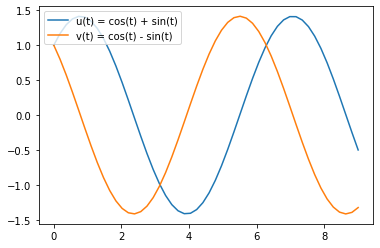

In [58]:
u0 = 1
v0 = 0

du = -v
dv = u
use_trapezoidal = True

res = Solver_two_equations(u0, v0, du, dv, use_trapezoidal)

time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=10, label='approximtion de u')
ax1.scatter(time, coords_v, s=10, label='approximation de v')
plt.xlim([0, 10])
plt.ylim([-10, 10])
plt.legend(loc='upper left');
plt.show()

graph = plt.subplot()
x = np.linspace(0, 9)
y = np.cos(x) + np.sin(x)
z = np.cos(x) - np.sin(x)
graph.plot(x, y, label ='u(t) = cos(t) + sin(t)')
graph.plot(x, z, label ='v(t) = cos(t) - sin(t)')
plt.legend(loc='upper left')  
plt.show()

## Solver for 4 differentials equations

In [5]:
def Solver_4_equations(u0, v0, f1, f2, use_trapezoidal):
    t0 = 0
    f_xk = 1
    uk_1 = u0
    vk_1 = v0
    xk_1 = np.array([u0, v0])
    xn_1_global = np.array([u0, v0])
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Suit of x and y variables
    y0 = u0*v0
    x0 = u0 + v0 - y0
    x = [x0]
    y = [y0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            # First step, we change our equation to F(x) = 0
            vec_f = create_2_f(xn_1_global, f1, f2, use_trapezoidal)
            
            #Creating F(xk-1)
            F_xk_1 = create_fxk_1(xk_1, vec_f)
            
            #Creating F'(xk-1)
            F_xk_1_prime = f_prime_2_eqs(xk_1, vec_f[0], vec_f[1])
        
            #Formula : xk = xk_1 - tr(F'(xk_1)) * F(xk_1)
            xk = xk_1 - np.dot(LA.inv(F_xk_1_prime), F_xk_1)
            
            #With the uk+1 and vk+1 calculated, we can calcul the x and y value.
            next_y = xk[0]*xk[1]
            next_x = xk[0] + xk[1] - next_y
            
            #Calcul of f(uk, vk, xk, yk) for the approximation
            f_xk = [0, 0, 0, 0]
            f_xk[0] = float(vec_f[0].evalf(subs={u: xk[0], v: xk[1]}))
            f_xk[1] = float(vec_f[1].evalf(subs={u: xk[0], v: xk[1]}))
            f_xk[2] = float(next_x)
            f_xk[3] = float(next_y)
            
            #2 types of check the approximation.
            norm_f_xk = LA.norm(f_xk)
            norm_xk = LA.norm(xk - xn_1_global)
            
            if(norm_xk < Epsilon or norm_f_xk < Epsilon):
                break
            
            xk_1 = xk
        
        #Update our 2 functions + time
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        
        #Update x and y variables
        x.append(next_x)
        y.append(next_y)
            
        #Update indexes
        xn_1_global = np.array([xk[0],xk[1]])
        f_xk = 1        
      
    return result_solver(time, fu, fv, x, y)

In [6]:
def solver_octave(u0, v0, f1, f2, use_trapezoidal):
    t0 = 0
    residu_tolerance = 1e-6
    residu_relative_tolerance = 1e-8
    
    exact_newton = True
    
    xn = [u0, v0]
    velocity_n = [-v0 , u0]
    xk = xn
    
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    
    while (t0 < interval):
        t0+= 0.1
        print("t0 = ", end='')
        print(t0)
        
        nb = 0
        has_newton_converged = False

        norm_residu_0 = 0
        norm_residu = 0
        relative_error = 0

        while (not(has_newton_converged) and nb < Nnewton):
            nb += 1
            
            vec_f = create_2_f(xn, f1, f2, use_trapezoidal, velocity_n)
            F_xk_1 = create_fxk_1(xk, vec_f)
            norm_residu = LA.norm(F_xk_1)
            
            
            print("vecf = ", end='')
            print(vec_f)
            print("fxk_1 = ", end='')
            print(F_xk_1)
            print("norme residu = ", end='')
            print(norm_residu)

            if(nb == 1):
                norm_residu_0 = norm_residu
            
            if(norm_residu_0 == 0):
                relative_error = 0
                
            else:
                relative_error = norm_residu / norm_residu_0
            
            if(relative_error < residu_relative_tolerance or norm_residu < residu_tolerance):
                has_newton_converged = True
                
            else:
                has_newton_converged = False
            
            if(not(has_newton_converged)):
                
                F_xk_1_prime = f_prime_2_eqs(xk, vec_f[0], vec_f[1])
                
                if (nb == 1 and not(exact_newton)):
                    update_jacobian = False
                
                
                xk += np.dot(LA.inv(F_xk_1_prime), F_xk_1)
                
                print("fxk_1_prime = ", end='')
                print(F_xk_1_prime)
                print("xk = ", end='')
                print(xk) 
            
            print("-----------------------")

        if(not(has_newton_converged) and nb == Nnewton):
            update_jacobian = True
            #t0 -= delta
            xk = xn
       
            
        #Update our 2 functions + time
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        
        #Update indexes
        velocity_n = [2*(xk[0] - xn[0]) / delta - velocity_n[0], 2*(xk[1] - xn[1]) / delta - velocity_n[1]]
        print("velocity_n = ")
        print(velocity_n)
        xn = xk
        print("________________________")
        
        
    return result_solver(time, fu, fv)